In [1]:
import os
from lsst.daf.butler import Butler
from lsst.afw import image as afwImage

from lsst.ts.wep.cwfs.Instrument import Instrument
from lsst.ts.wep.Utility import runProgram, writePipetaskCmd, getConfigDir, CamType
from lsst.ts.wep.task.EstimateZernikesCwfsTask import EstimateZernikesCwfsTask, EstimateZernikesCwfsTaskConfig

import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import rotate
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
butler_repo_orig = 'testData/blendedTest/phosimData/'
butler_repo_new = 'testData/blendedTest_2/phosimData/'

In [3]:
butler_orig = Butler(butler_repo_orig)
butler_new = Butler(butler_repo_new)

In [4]:
dataIdExtra = {
    'instrument': 'LSSTComCam', 
    'detector': 4, 
    'exposure': 4021123106001,
    'visit': 4021123106001
}
dataIdIntra = {
    'instrument': 'LSSTComCam', 
    'detector': 4, 
    'exposure': 4021123106002,
    'visit': 4021123106002
}
donutStampsExtra = butler_new.get('donutStampsExtra', dataId=dataIdExtra, collections='baseline_blended')
donutStampsIntra = butler_new.get('donutStampsIntra', dataId=dataIdExtra, collections='baseline_blended')

In [5]:
len(donutStampsExtra)

1

In [6]:
donutStampExtra = donutStampsExtra[0]
donutStampIntra = donutStampsIntra[0]

In [7]:
donutStampExtraArray = donutStampExtra.stamp_im.getImage().getArray()

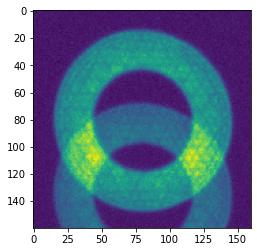

In [8]:
plt.imshow(donutStampExtraArray)

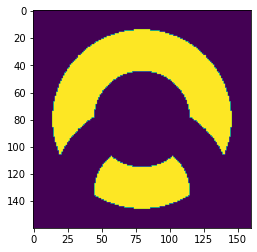

In [9]:
plt.imshow(donutStampExtra.stamp_im.getMask().getArray())

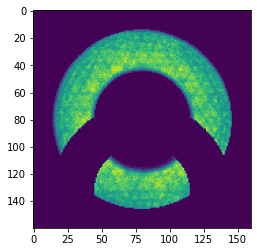

In [31]:
plt.imshow(donutStampExtra.stamp_im.getMask().getArray()*donutStampExtraArray)

In [10]:
camera = butler_new.get(
    "camera",
    dataId={"instrument": "LSSTComCam"},
    collections="LSSTComCam/calib/unbounded",
)

In [11]:
camera.getName()

'LSSTComCam'

In [12]:
donutCatalogExtra = butler_new.get('donutCatalog', dataId=dataIdExtra, collections='baseline_blended')

In [13]:
donutCatalogIntra = butler_new.get('donutCatalog', dataId=dataIdIntra, collections='baseline_blended')

In [14]:
donutCatalogExtra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,0.0,0.0,2036.5,2000.5,3.630781e+06,[2036.499999999937],[2054.5000000492705]


In [15]:
donutCatalogIntra

,coord_ra,coord_dec,centroid_x,centroid_y,source_flux,blend_centroid_x,blend_centroid_y
0,0.0,0.0,2036.5,2000.5,3.630781e+06,[2036.499999999937],[2054.5000000492705]


In [16]:
zern_est_orig = butler_orig.get('zernikeEstimateRaw', dataId=dataIdExtra, collections='ts_phosim_9006001')

In [17]:
zern_est_blended_baseline = butler_new.get('zernikeEstimateRaw', dataId=dataIdExtra, collections='baseline_blended')

In [18]:
opd_truth = np.genfromtxt('testData/blendedTest_2/iter0/img/opd.zer')

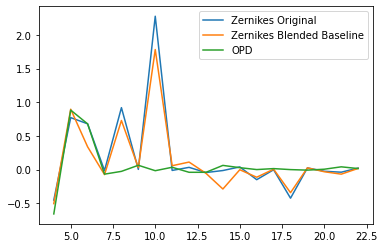

In [19]:
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original')
plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline')
plt.plot(np.arange(4,23), opd_truth[4], label='OPD')
plt.legend()

In [20]:
from lsst.ts.wep.task.CalcZernikesTask import CalcZernikesTask, CalcZernikesTaskConfig

In [21]:
calcZernConfig = CalcZernikesTaskConfig()

In [22]:
calcZernConfig

lsst.ts.wep.task.CalcZernikesTask.CalcZernikesTaskConfig(saveMetadata=True, saveLogOutput=True, combineZernikes={'sigma': 3.0, 'maxZernClip': 3}, connections={'donutStampsExtra': 'donutStampsExtra', 'donutStampsIntra': 'donutStampsIntra', 'outputZernikesRaw': 'zernikeEstimateRaw', 'outputZernikesAvg': 'zernikeEstimateAvg'})

In [23]:
calcZernTask = CalcZernikesTask(config=calcZernConfig)

In [24]:
donutStampsIntra[0].centroid_position = donutStampsExtra[0].centroid_position

In [25]:
zern_est_new = calcZernTask.run(donutStampsExtra, donutStampsIntra)

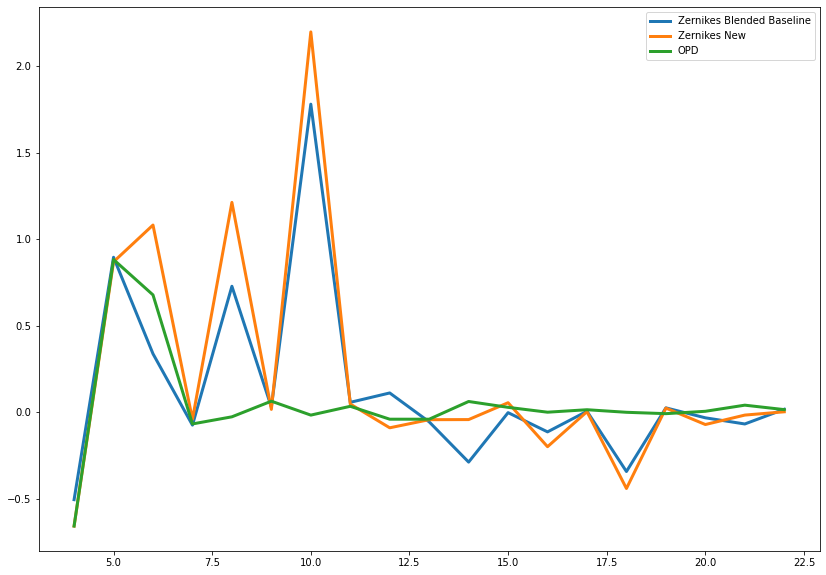

In [26]:
fig = plt.figure(figsize=(14, 10))
#plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original', lw=3)
plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline', lw=3)
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New', lw=3)
plt.plot(np.arange(4,23), opd_truth[4], label='OPD', lw=3)
plt.legend()

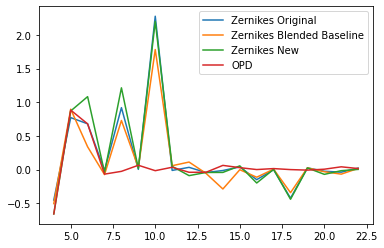

In [27]:
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original')
plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline')
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New')
plt.plot(np.arange(4,23), opd_truth[4], label='OPD')
plt.legend()

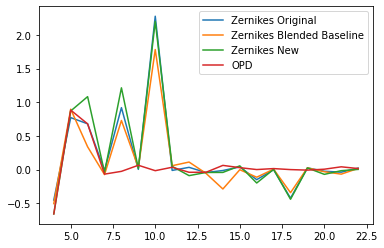

In [28]:
plt.plot(np.arange(4,23), zern_est_orig[0], label='Zernikes Original')
plt.plot(np.arange(4,23), zern_est_blended_baseline[0], label='Zernikes Blended Baseline')
plt.plot(np.arange(4,23), zern_est_new.outputZernikesRaw[0], label='Zernikes New')
plt.plot(np.arange(4,23), opd_truth[4], label='OPD')
plt.legend()

In [29]:
donutStampExtra

DonutStamp(stamp_im=lsst.afw.image.maskedImage.MaskedImageF=(image=[[-11.385272  -22.694872    5.579128  ...   9.864551  -12.823449
  -17.077448 ]
 [  5.579128   18.302427  -21.281172  ... -14.241448    1.356551
    7.028551 ]
 [  4.1654277  -7.144172   -5.730472  ...  -1.4794489  -1.4794489
   -4.3154488]
 ...
 [ -6.8380837  18.787216  -20.325085  ... -10.775775   -4.0412755
    2.6932244]
 [ -5.4893837   9.346316   -8.186784  ...  -1.3474754   2.6932244
   -6.7350755]
 [  1.2541165   9.346316   17.438517  ...  18.856024    1.3463246
  -12.122675 ]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'BKGRD': 9, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'DONUT': 10, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}
variance=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 

In [30]:
donutStampIntra

DonutStamp(stamp_im=lsst.afw.image.maskedImage.MaskedImageF=(image=[[ -4.3521495 -17.075449   -4.3521495 ...   5.6341786   9.888179
  -11.381822 ]
 [  4.1300507   8.371151    1.3026507 ... -22.72582     2.7981787
  -14.217821 ]
 [-21.31655    -7.179549  -12.83435   ...  11.306178    7.0521784
  -15.635821 ]
 ...
 [-17.556314    6.7202864  -2.7206137 ... -13.471795    2.691005
   -5.390395 ]
 [ -6.766714   24.253387    1.3254863 ...  14.813105  -13.471795
   13.466205 ]
 [ -2.7206137  -1.3719138   6.7202864 ... -10.777995   -1.3496951
   10.772405 ]],
mask=[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]], maskPlaneDict={'BAD': 0, 'BKGRD': 9, 'CR': 3, 'DETECTED': 5, 'DETECTED_NEGATIVE': 6, 'DONUT': 10, 'EDGE': 4, 'INTRP': 2, 'NO_DATA': 8, 'SAT': 1, 'SUSPECT': 7}
variance=[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0